In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, Input, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import random
from scipy import ndimage
from skimage import exposure
from sklearn.model_selection import train_test_split
import cv2

In [39]:
import tensorflow as tf

# Check if a GPU is available
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

# Check TensorFlow is using GPU
print("Is TensorFlow using GPU:", tf.test.is_built_with_cuda())
print("GPU Devices:", tf.config.experimental.list_physical_devices('GPU'))


Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Is TensorFlow using GPU: True
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [40]:
import os
import shutil
import random

# Define weather classes and root/output directories
weather_class = ['rainbow', 'snow', 'rain', 'lightning', 'sandstorm']
root_folder = '/kaggle/input/weather-dataset/dataset/'  # Path to the original dataset
output_folder = '/kaggle/working/filtered_images/'  # Path to save the filtered images

# Create output folders for each class if they don't exist
for cls in weather_class:
    os.makedirs(os.path.join(output_folder, cls), exist_ok=True)

# Function to copy a specified number of random images from a class
def copy_images(class_name, num_images=200):
    """
    Copies a specified number of random images from a class folder to the output folder.

    Args:
        class_name (str): Name of the class (e.g., 'rainbow', 'snow').
        num_images (int): Number of images to copy (default is 200).
    """
    class_path = os.path.join(root_folder, class_name)  # Path to the class folder
    images = os.listdir(class_path)  # List all images in the class folder

    # Check if there are enough images in the class folder
    if len(images) < num_images:
        raise ValueError(f"Not enough images in class {class_name}. Required: {num_images}, Available: {len(images)}")

    # Randomly select 'num_images' from the list of images
    selected_images = random.sample(images, num_images)

    # Copy each selected image to the output folder
    for img in selected_images:
        src = os.path.join(class_path, img)  # Source path of the image
        dst = os.path.join(output_folder, class_name, img)  # Destination path
        shutil.copy(src, dst)  # Copy the image

# Copy 200 images for each class
for cls in weather_class:
    copy_images(cls)

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = (150, 150)  # Resize all images to 150x150 pixels
batch_size = 32  # Number of images processed in each batch

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # Fill missing pixels with the nearest value
    validation_split=0.2  # 20% of the data will be used for validation
)

# Preprocessing for validation data (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Use the same 20% split for validation
)

# Load training images from the output folder
train_generator = train_datagen.flow_from_directory(
    output_folder,  # Path to the folder containing class subfolders
    target_size=img_size,  # Resize images to 150x150
    batch_size=batch_size,  # Number of images per batch
    class_mode='categorical',  # Use categorical labels (one-hot encoding)
    subset='training',  # Specify this is the training subset
    shuffle=True  # Shuffle the data for better training
)

# Load validation images from the output folder
validation_generator = validation_datagen.flow_from_directory(
    output_folder,  # Path to the folder containing class subfolders
    target_size=img_size,  # Resize images to 150x150
    batch_size=batch_size,  # Number of images per batch
    class_mode='categorical',  # Use categorical labels (one-hot encoding)
    subset='validation',  # Specify this is the validation subset
    shuffle=False  # Do not shuffle the validation data
)

Found 1732 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # 32 filters, 3x3 kernel
    MaxPooling2D(2, 2),  # 2x2 pooling

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
    MaxPooling2D(2, 2),  # 2x2 pooling

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),  # 128 filters, 3x3 kernel
    MaxPooling2D(2, 2),  # 2x2 pooling

    # Flatten the output for dense layers
    Flatten(),

    # Fully connected (dense) layer
    Dense(512, activation='relu'),  # 512 neurons
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer
    Dense(len(weather_class), activation='softmax')  # Softmax for multi-class classification
])

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [50]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

# Print the model summary
model.summary()

# Define callbacks for optimization
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop training if validation loss doesn't improve for 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)  # Reduce learning rate if validation loss plateaus
]


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,229 (72.62 MB)

 Trainable params: 19,036,229 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    validation_data=validation_generator,  # Validation data generator
    validation_steps=validation_generator.samples // batch_size,  # Number of validation steps
    epochs=30,  # Number of epochs
    callbacks=callbacks  # Callbacks for optimization
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 241ms/step - accuracy: 0.4702 - loss: 1.4087 - val_accuracy: 0.6683 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6250 - loss: 0.8117 - val_accuracy: 0.8571 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.6845 - loss: 0.7904 - val_accuracy: 0.6418 - val_loss: 0.7909 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.6344 - val_accuracy: 0.8571 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.7533 - loss: 0.6508 - val_accuracy: 0.7861 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.7500 - loss: 0.7619 - val_accuracy: 0.8571 - val_loss: 0.6330 - learning_rate: 0.0010
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.8255 - loss: 0.5027 - 

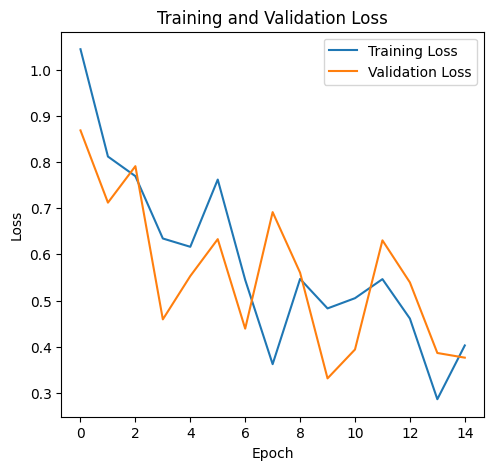

In [52]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

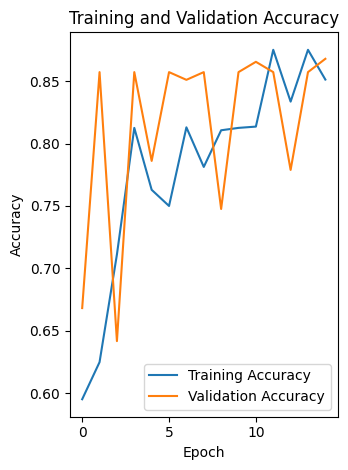

In [54]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6462 - loss: 0.7816
Validation Loss: 0.616615355014801
Validation Accuracy: 0.7255814075469971


In [58]:
# Save the model
model.save('/kaggle/working/weather_detection_model.h5')

In [57]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to predict the class of a new image
def predict_weather(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    prediction = model.predict(img_array)
    predicted_class = weather_class[np.argmax(prediction)]
    
    return predicted_class

# Example usage
new_image_path = '/kaggle/input/weather-dataset/dataset/glaze/6091.jpg'
predicted_weather = predict_weather(new_image_path)
print(f'The predicted weather is: {predicted_weather}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
The predicted weather is: sandstorm
